# Importing The Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generating Sinc Function

In [3]:
def sinc_function(x):
    return np.where(x == 0, 1.0, np.sin(x) / x)

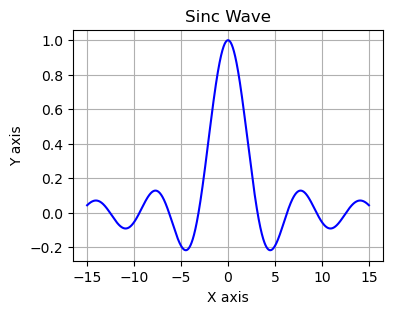

In [4]:
X_range = np.linspace(-15, 15, 10000).reshape(-1, 1)
Y_range = sinc_function(X_range)
plt.figure(figsize=(4, 3))
plt.plot(X_range, Y_range, 'b-')
plt.title('Sinc Wave')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.grid(True)
plt.show()
plt.close()

# Sampling The Function

In [5]:
def generate_samples(n_samples, x_range=(-15, 15)):
    x = np.linspace(x_range[0], x_range[1], n_samples)
    y_true = sinc_function(x)
    return x, y_true

In [6]:
n_samples_list=[100, 300, 1000]
x_samples = {}
y_true_samples = {}
for n_samples in n_samples_list:
    x, y_true = generate_samples(n_samples)
    x_samples[n_samples] = x
    y_true_samples[n_samples] = y_true

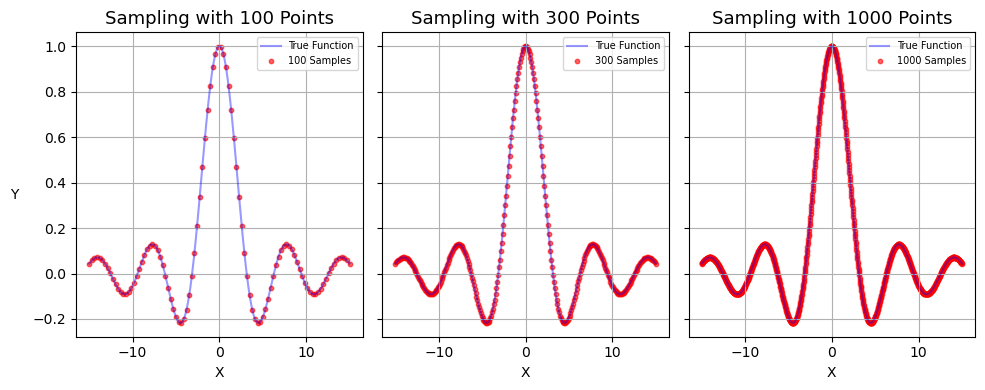

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
fig.supylabel('Y ', rotation=0, fontsize=10)

for i in range(3):
    axes[i].plot(X_range, Y_range, 'b-', alpha=0.4, label='True Function')
    axes[i].scatter(x_samples[n_samples_list[i]], y_true_samples[n_samples_list[i]], 
                     c='red', s=10, alpha=0.6, label=f'{n_samples_list[i]} Samples')
    axes[i].set_xlabel('X', fontsize=10)
    axes[i].set_title(f'Sampling with {n_samples_list[i]} Points', fontsize=13)
    axes[i].grid(True)
    axes[i].legend(fontsize=7)

plt.tight_layout()
plt.show()

# Add Gaussian Noise

In [8]:
def add_noise(y_true, noise_level='Clean'):
    if noise_level == 'Clean':
        variance = 0.01
    else:  # noisy
        variance = 0.1
    return y_true + np.random.normal(0, np.sqrt(variance), len(y_true))

In [9]:
noisy_y_true_samples = {}
for n_samples in n_samples_list:
    noisy_y_true = add_noise(y_true_samples[n_samples])
    noisy_y_true_samples[n_samples] = noisy_y_true

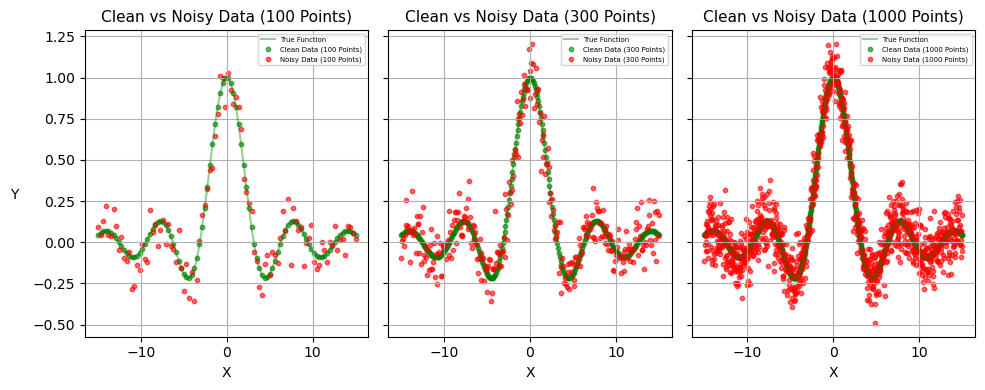

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
fig.supylabel('Y ', rotation=0, fontsize=10)

for i in range(3):
    axes[i].plot(X_range, Y_range, 'g-', alpha=0.4, label='True Function')
    axes[i].scatter(x_samples[n_samples_list[i]], y_true_samples[n_samples_list[i]], 
                     c='green', s=10, alpha=0.6, label=f'Clean Data ({n_samples_list[i]} Points)')
    axes[i].scatter(x_samples[n_samples_list[i]], noisy_y_true_samples[n_samples_list[i]], 
                     c='red', s=10, alpha=0.6, label=f'Noisy Data ({n_samples_list[i]} Points)')
    axes[i].set_xlabel('X', fontsize=10)
    axes[i].set_title(f'Clean vs Noisy Data ({n_samples_list[i]} Points)', fontsize=11)
    axes[i].grid(True)
    axes[i].legend(fontsize=5)

plt.tight_layout()
plt.show()

# Function Estimation 

In [11]:
# We will use this function in "Function Estimation With Outliers"
def add_outliers(y, outlier_percentage=0.03):
    """Add outliers to the data"""
    n_outliers = int(len(y) * outlier_percentage)
    outlier_indices = np.random.choice(len(y), n_outliers, replace=False)
    
    y_with_outliers = y.copy()
    for idx in outlier_indices:
        # Add large deviation (positive or negative)
        deviation = np.random.choice([-1, 1]) * np.random.uniform(2, 5)
        y_with_outliers[idx] += deviation
    
    return y_with_outliers, outlier_indices

In [12]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, mae

In [13]:
def analyze_regression_models(n_samples_list, noise_levels, add_outliers_flag=False):
    results = {}
    
    for n_samples in n_samples_list:
        print(f"Analyzing with {n_samples} samples")
        if add_outliers_flag:
            print("With Outliers")
        print(f"{'='*50}")
        
        results[n_samples] = {}
        
        for noise_level in noise_levels:
            print(f"\nNoise level: {noise_level}")
          
            x, y_true = generate_samples(n_samples)
            y_noisy = add_noise(y_true, noise_level)
            
            if add_outliers_flag:
                y_data, outlier_indices = add_outliers(y_noisy)
            else:
                y_data = y_noisy
                outlier_indices = []
            
            x_reshaped = x.reshape(-1, 1)
            x_train, x_test, y_train, y_test = train_test_split(
                x_reshaped, y_data, test_size=0.2, random_state=42
            )
            
            
            results[n_samples][noise_level] = {
                'linear': {'mse': [], 'mae': [], 'degrees': [1]},
                'polynomial': {'mse': [], 'mae': [], 'degrees': []},
                'ridge': {'mse': [], 'mae': [], 'alphas': []},
                'lasso': {'mse': [], 'mae': [], 'alphas': []},
                'elasticnet': {'mse': [], 'mae': [], 'alphas': []}
            }
            
            # Simple Linear Regression
            print("Simple Linear Regression:")
            lin_reg = LinearRegression()
            lin_reg.fit(x_train, y_train)
            y_pred_lin = lin_reg.predict(x_test)
            mse_lin, mae_lin = evaluate_model(sinc_function(x_test.flatten()), y_pred_lin)
            results[n_samples][noise_level]['linear']['mse'].append(mse_lin)
            results[n_samples][noise_level]['linear']['mae'].append(mae_lin)
            print(f"  MSE: {mse_lin:.4f}, MAE: {mae_lin:.4f}")
            
            # Polynomial Regression
            print("\nPolynomial Regression:")
            max_degree = min(n_samples // 10, 50)
            degrees = range(2, max_degree + 1)
            
            best_poly_degree = 2
            best_poly_mse = float('inf')
            
            for degree in degrees:
                poly_reg = Pipeline([
                    ('poly', PolynomialFeatures(degree=degree)),
                    ('linear', LinearRegression())
                ])
                
                poly_reg.fit(x_train, y_train)
                y_pred_poly = poly_reg.predict(x_test)
                mse_poly, mae_poly = evaluate_model(sinc_function(x_test.flatten()), y_pred_poly)
                
                results[n_samples][noise_level]['polynomial']['mse'].append(mse_poly)
                results[n_samples][noise_level]['polynomial']['mae'].append(mae_poly)
                results[n_samples][noise_level]['polynomial']['degrees'].append(degree)
                
                if mse_poly < best_poly_mse:
                    best_poly_mse = mse_poly
                    best_poly_degree = degree
                
                if degree <= 5 or (degree % 10 == 0):
                    print(f"  Degree {degree}: MSE: {mse_poly:.4f}, MAE: {mae_poly:.4f}")
            
            print(f"  Best degree: {best_poly_degree} with MSE: {best_poly_mse:.4f}")
            
            # Regularized Regression
            print("\nRegularized Regression:")
            
            # Ridge Regression
            print("Ridge Regression:")
            alpha_values_ridge = np.logspace(-6, 2, 20)
            best_ridge_alpha = 1.0
            best_ridge_mse = float('inf')
            
            for alpha in alpha_values_ridge:
                ridge = Ridge(alpha=alpha, random_state=42)
                ridge.fit(x_train, y_train)
                y_pred_ridge = ridge.predict(x_test)
                mse_ridge, mae_ridge = evaluate_model(sinc_function(x_test.flatten()), y_pred_ridge)
                
                results[n_samples][noise_level]['ridge']['mse'].append(mse_ridge)
                results[n_samples][noise_level]['ridge']['mae'].append(mae_ridge)
                results[n_samples][noise_level]['ridge']['alphas'].append(alpha)
                
                if mse_ridge < best_ridge_mse:
                    best_ridge_mse = mse_ridge
                    best_ridge_alpha = alpha
            
            print(f"  Best alpha: {best_ridge_alpha:.6f}, MSE: {best_ridge_mse:.4f}")
            
            # Lasso Regression
            print("Lasso Regression:")
            alpha_values_lasso = np.logspace(-6, 0, 20)
            best_lasso_alpha = 1.0
            best_lasso_mse = float('inf')
            
            for alpha in alpha_values_lasso:
                lasso = Lasso(alpha=alpha, random_state=42, max_iter=10000)
                lasso.fit(x_train, y_train)
                y_pred_lasso = lasso.predict(x_test)
                mse_lasso, mae_lasso = evaluate_model(sinc_function(x_test.flatten()), y_pred_lasso)
                
                results[n_samples][noise_level]['lasso']['mse'].append(mse_lasso)
                results[n_samples][noise_level]['lasso']['mae'].append(mae_lasso)
                results[n_samples][noise_level]['lasso']['alphas'].append(alpha)
                
                if mse_lasso < best_lasso_mse:
                    best_lasso_mse = mse_lasso
                    best_lasso_alpha = alpha
            
            print(f"  Best alpha: {best_lasso_alpha:.6f}, MSE: {best_lasso_mse:.4f}")
            
            # ElasticNet Regression
            print("ElasticNet Regression:")
            alpha_values_elastic = np.logspace(-6, 0, 15)
            best_elastic_alpha = 1.0
            best_elastic_mse = float('inf')
            
            for alpha in alpha_values_elastic:
                elastic = ElasticNet(alpha=alpha, l1_ratio=0.5, random_state=42, max_iter=10000)
                elastic.fit(x_train, y_train)
                y_pred_elastic = elastic.predict(x_test)
                mse_elastic, mae_elastic = evaluate_model(sinc_function(x_test.flatten()), y_pred_elastic)
                
                results[n_samples][noise_level]['elasticnet']['mse'].append(mse_elastic)
                results[n_samples][noise_level]['elasticnet']['mae'].append(mae_elastic)
                results[n_samples][noise_level]['elasticnet']['alphas'].append(alpha)
                
                if mse_elastic < best_elastic_mse:
                    best_elastic_mse = mse_elastic
                    best_elastic_alpha = alpha
            
            print(f"  Best alpha: {best_elastic_alpha:.6f}, MSE: {best_elastic_mse:.4f}")
    
    return results

In [14]:
n_samples_list = [100, 300, 1000]
noise_levels = ['Clean', 'Noisy']
results_no_outliers = analyze_regression_models(n_samples_list, noise_levels, add_outliers_flag=False)

Analyzing with 100 samples

Noise level: Clean
Simple Linear Regression:
  MSE: 0.0734, MAE: 0.2012

Polynomial Regression:
  Degree 2: MSE: 0.0617, MAE: 0.1928
  Degree 3: MSE: 0.0660, MAE: 0.1991
  Degree 4: MSE: 0.0493, MAE: 0.1779
  Degree 5: MSE: 0.0532, MAE: 0.1847
  Degree 10: MSE: 0.0220, MAE: 0.1123
  Best degree: 10 with MSE: 0.0220

Regularized Regression:
Ridge Regression:
  Best alpha: 100.000000, MSE: 0.0734
Lasso Regression:
  Best alpha: 0.000695, MSE: 0.0734
ElasticNet Regression:
  Best alpha: 0.002683, MSE: 0.0734

Noise level: Noisy
Simple Linear Regression:
  MSE: 0.0797, MAE: 0.2118

Polynomial Regression:
  Degree 2: MSE: 0.0623, MAE: 0.1871
  Degree 3: MSE: 0.0753, MAE: 0.2203
  Degree 4: MSE: 0.0619, MAE: 0.1997
  Degree 5: MSE: 0.0604, MAE: 0.2003
  Degree 10: MSE: 0.1268, MAE: 0.1981
  Best degree: 8 with MSE: 0.0492

Regularized Regression:
Ridge Regression:
  Best alpha: 100.000000, MSE: 0.0795
Lasso Regression:
  Best alpha: 1.000000, MSE: 0.0727
ElasticNe

# Perfomance Analysis

In [15]:
def plot_error_analysis(results, n_samples_list, noise_levels, add_outliers_flag=False):
    
    for n_samples in n_samples_list:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle(f'Error Analysis - {n_samples} Samples{" with Outliers" if add_outliers_flag else ""}', fontsize=16)
        
        for i, noise_level in enumerate(noise_levels):
            data = results[n_samples][noise_level]
            
            # Polynomial Regression Errors
            degrees = data['polynomial']['degrees']
            axes[0, 0].semilogy(degrees, data['polynomial']['mse'], 
                               marker='o', label=f'{noise_level} noise')
            axes[0, 0].set_title('Polynomial Regression - MSE')
            axes[0, 0].set_xlabel('Degree')
            axes[0, 0].set_ylabel('MSE (log scale)')
            axes[0, 0].grid(True)
            axes[0, 0].legend()
            
            axes[1, 0].semilogy(degrees, data['polynomial']['mae'], 
                               marker='o', label=f'{noise_level} noise')
            axes[1, 0].set_title('Polynomial Regression - MAE')
            axes[1, 0].set_xlabel('Degree')
            axes[1, 0].set_ylabel('MAE (log scale)')
            axes[1, 0].grid(True)
            axes[1, 0].legend()
            
            # Ridge Regression Errors
            alphas_ridge = data['ridge']['alphas']
            axes[0, 1].semilogy(alphas_ridge, data['ridge']['mse'], 
                               marker='o', label=f'{noise_level} noise')
            axes[0, 1].set_title('Ridge Regression - MSE')
            axes[0, 1].set_xlabel('Alpha')
            axes[0, 1].set_ylabel('MSE (log scale)')
            axes[0, 1].grid(True)
            axes[0, 1].legend()
            
            axes[1, 1].semilogy(alphas_ridge, data['ridge']['mae'], 
                               marker='o', label=f'{noise_level} noise')
            axes[1, 1].set_title('Ridge Regression - MAE')
            axes[1, 1].set_xlabel('Alpha')
            axes[1, 1].set_ylabel('MAE (log scale)')
            axes[1, 1].grid(True)
            axes[1, 1].legend()
            
            # Lasso Regression Errors
            alphas_lasso = data['lasso']['alphas']
            axes[0, 2].semilogy(alphas_lasso, data['lasso']['mse'], 
                               marker='o', label=f'{noise_level} noise')
            axes[0, 2].set_title('Lasso Regression - MSE')
            axes[0, 2].set_xlabel('Alpha')
            axes[0, 2].set_ylabel('MSE (log scale)')
            axes[0, 2].grid(True)
            axes[0, 2].legend()
            
            axes[1, 2].semilogy(alphas_lasso, data['lasso']['mae'], 
                               marker='o', label=f'{noise_level} noise')
            axes[1, 2].set_title('Lasso Regression - MAE')
            axes[1, 2].set_xlabel('Alpha')
            axes[1, 2].set_ylabel('MAE (log scale)')
            axes[1, 2].grid(True)
            axes[1, 2].legend()
        
        plt.tight_layout()
        plt.show()

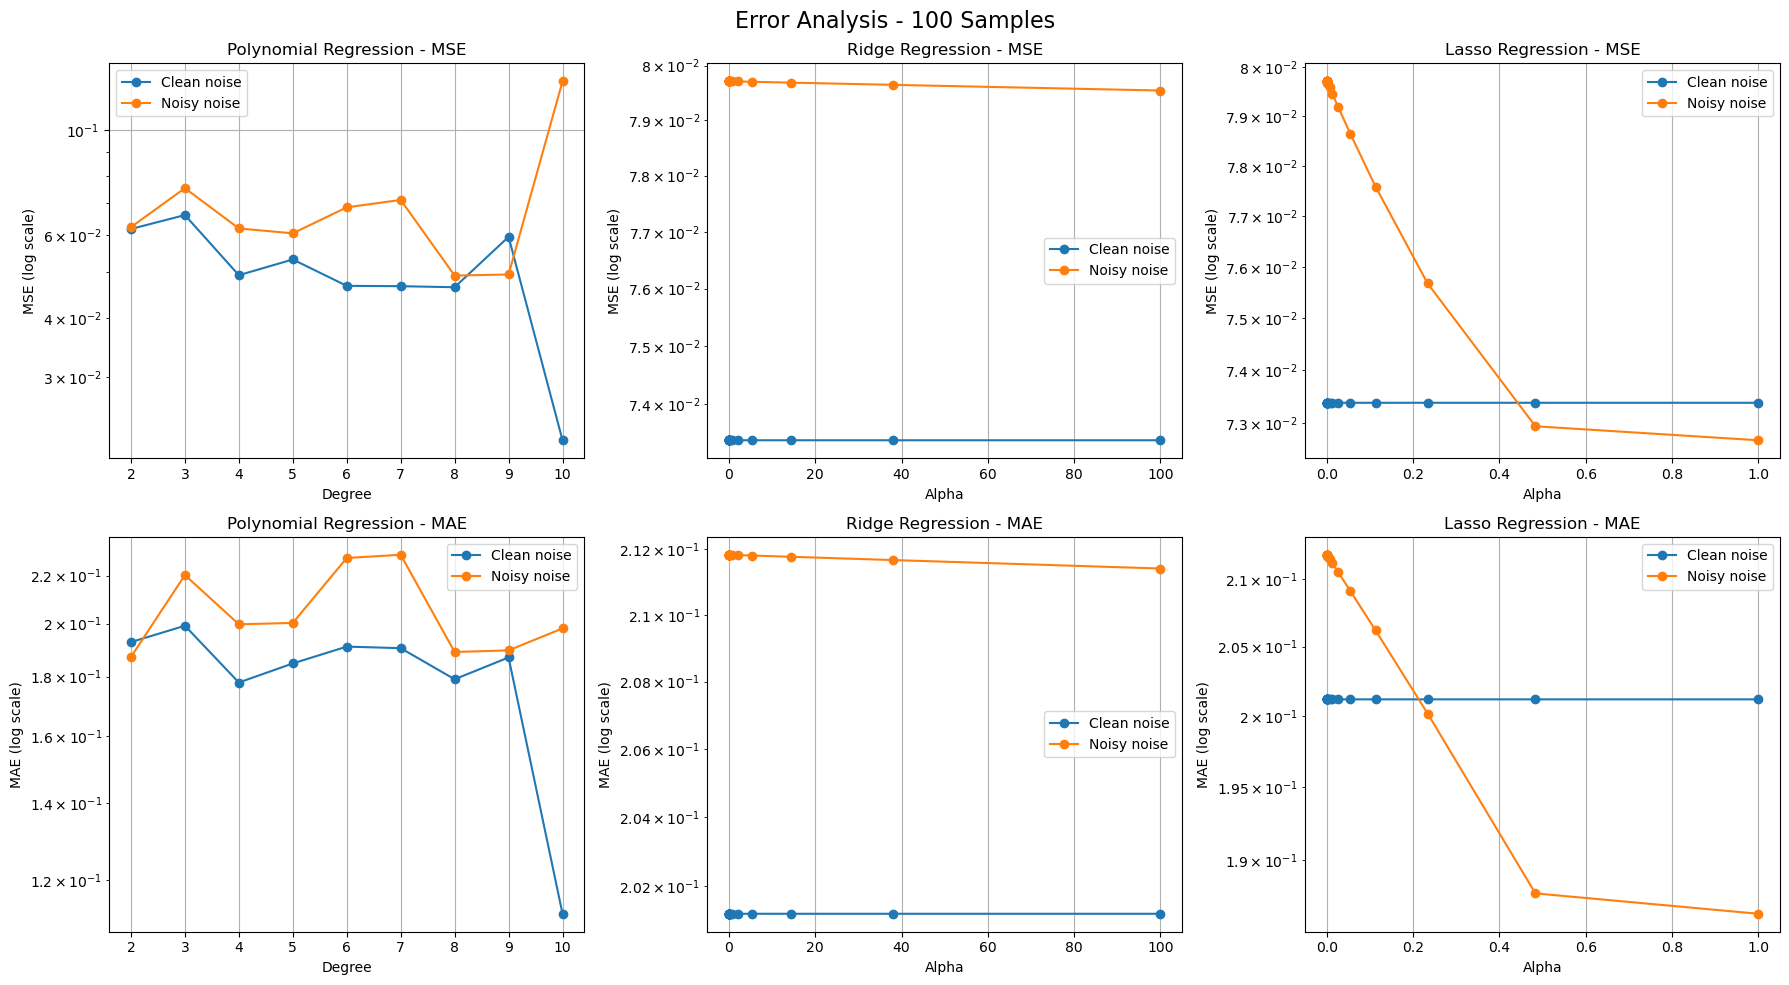

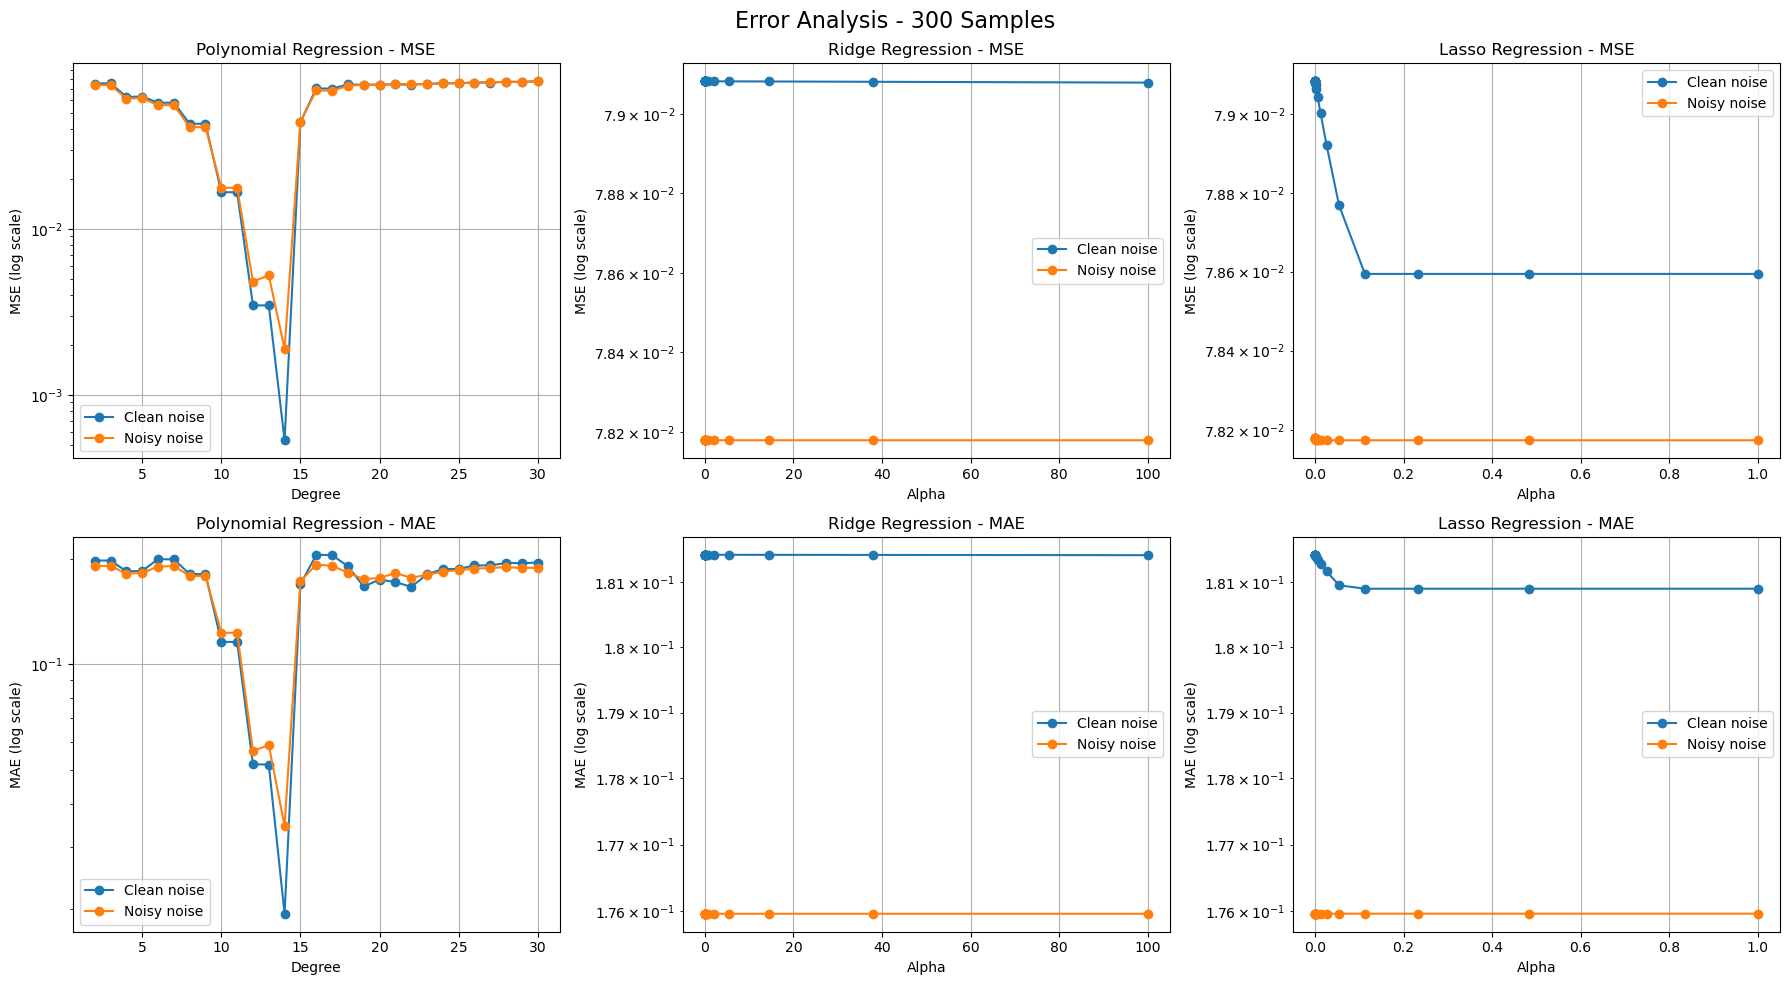

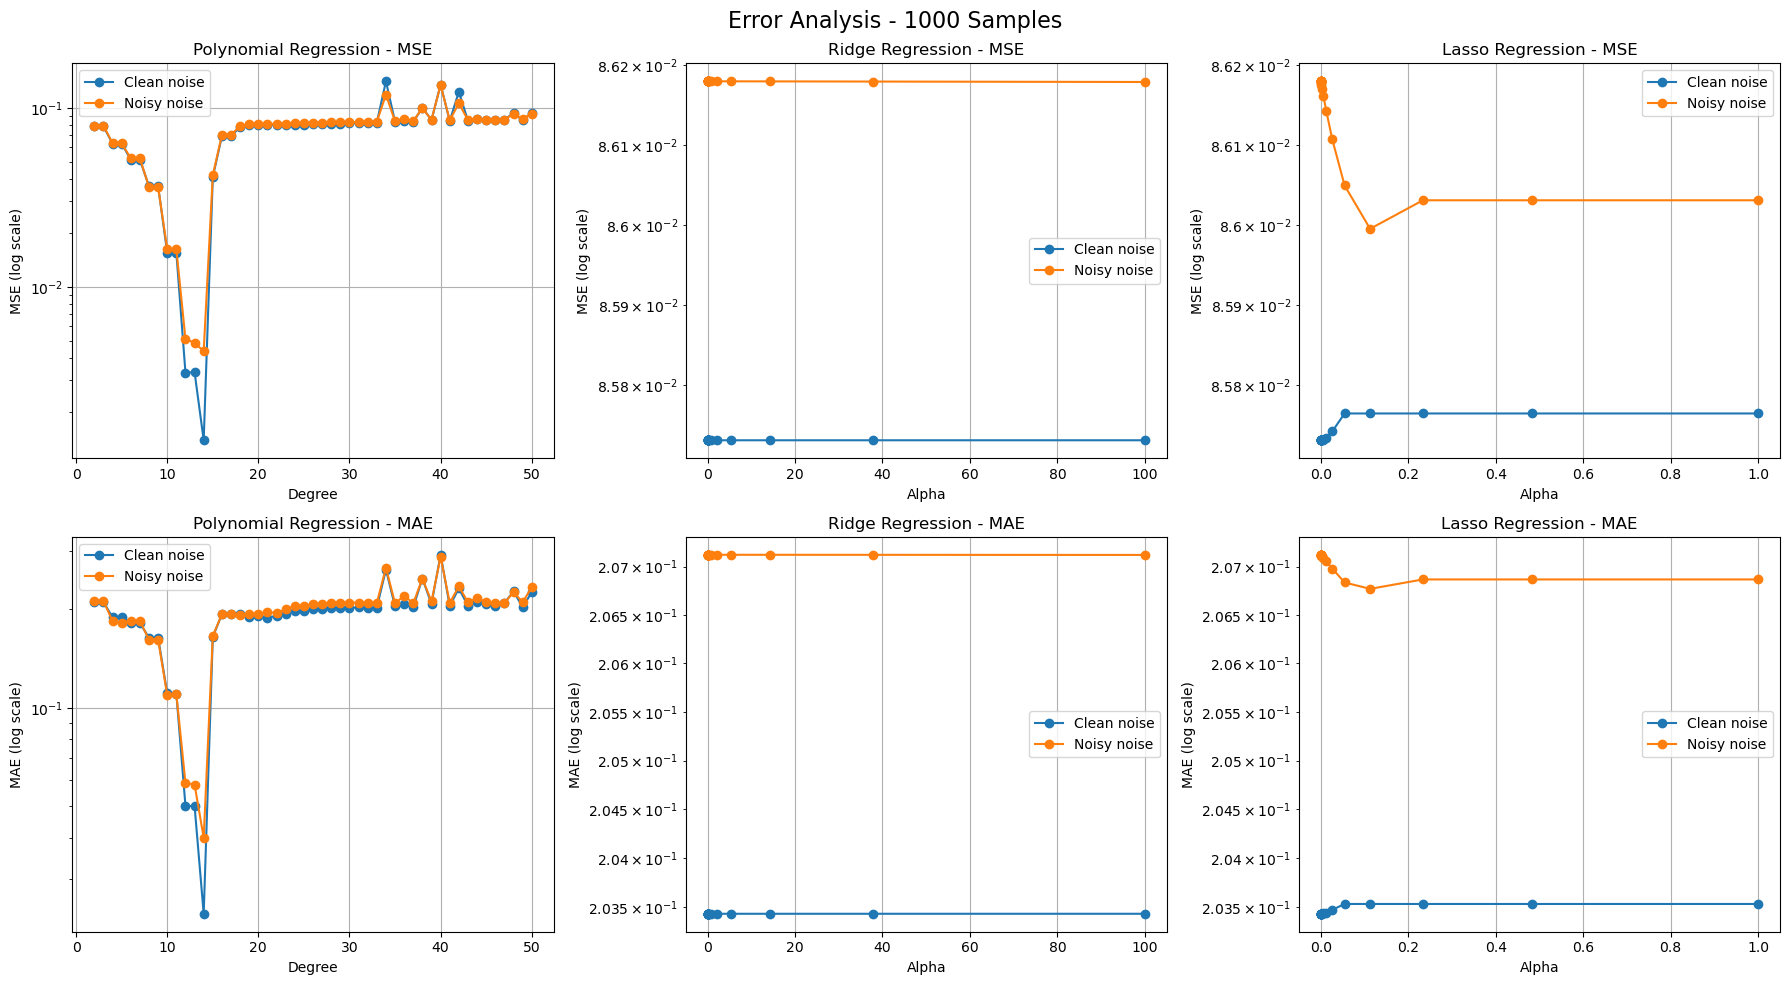

In [16]:
plot_error_analysis(results_no_outliers, n_samples_list, noise_levels, add_outliers_flag=False)

# Comparison 

In [17]:
def plot_comparison(results, n_samples_list, noise_levels, add_outliers_flag=False):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Model Comparison{" with Outliers" if add_outliers_flag else ""}', fontsize=16)
    
    models = ['linear', 'polynomial', 'ridge', 'lasso', 'elasticnet']
    model_names = ['Linear', 'Polynomial', 'Ridge', 'Lasso', 'ElasticNet']
    
    for i, noise_level in enumerate(noise_levels):
        mse_results = []
        mae_results = []
        
        for n_samples in n_samples_list:
            data = results[n_samples][noise_level]
            
            # Get best MSE and MAE for each model
            best_mse = []
            best_mae = []
            
            # Linear
            best_mse.append(min(data['linear']['mse']))
            best_mae.append(min(data['linear']['mae']))
            
            # Polynomial
            best_mse.append(min(data['polynomial']['mse']))
            best_mae.append(min(data['polynomial']['mae']))
            
            # Ridge
            best_mse.append(min(data['ridge']['mse']))
            best_mae.append(min(data['ridge']['mae']))
            
            # Lasso
            best_mse.append(min(data['lasso']['mse']))
            best_mae.append(min(data['lasso']['mae']))
            
            # ElasticNet
            best_mse.append(min(data['elasticnet']['mse']))
            best_mae.append(min(data['elasticnet']['mae']))
            
            mse_results.append(best_mse)
            mae_results.append(best_mae)
        
        # Plot MSE
        x_pos = np.arange(len(models))
        width = 0.25
        
        for j, n_samples in enumerate(n_samples_list):
            axes[0, i].bar(x_pos + j*width, mse_results[j], width, 
                          label=f'{n_samples} samples', alpha=0.8)
        
        axes[0, i].set_title(f'MSE Comparison - {noise_level} noise')
        axes[0, i].set_xlabel('Model')
        axes[0, i].set_ylabel('MSE')
        axes[0, i].set_xticks(x_pos + width)
        axes[0, i].set_xticklabels(model_names, rotation=45)
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)
        
        # Plot MAE
        for j, n_samples in enumerate(n_samples_list):
            axes[1, i].bar(x_pos + j*width, mae_results[j], width, 
                          label=f'{n_samples} samples', alpha=0.8)
        
        axes[1, i].set_title(f'MAE Comparison - {noise_level} noise')
        axes[1, i].set_xlabel('Model')
        axes[1, i].set_ylabel('MAE')
        axes[1, i].set_xticks(x_pos + width)
        axes[1, i].set_xticklabels(model_names, rotation=45)
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

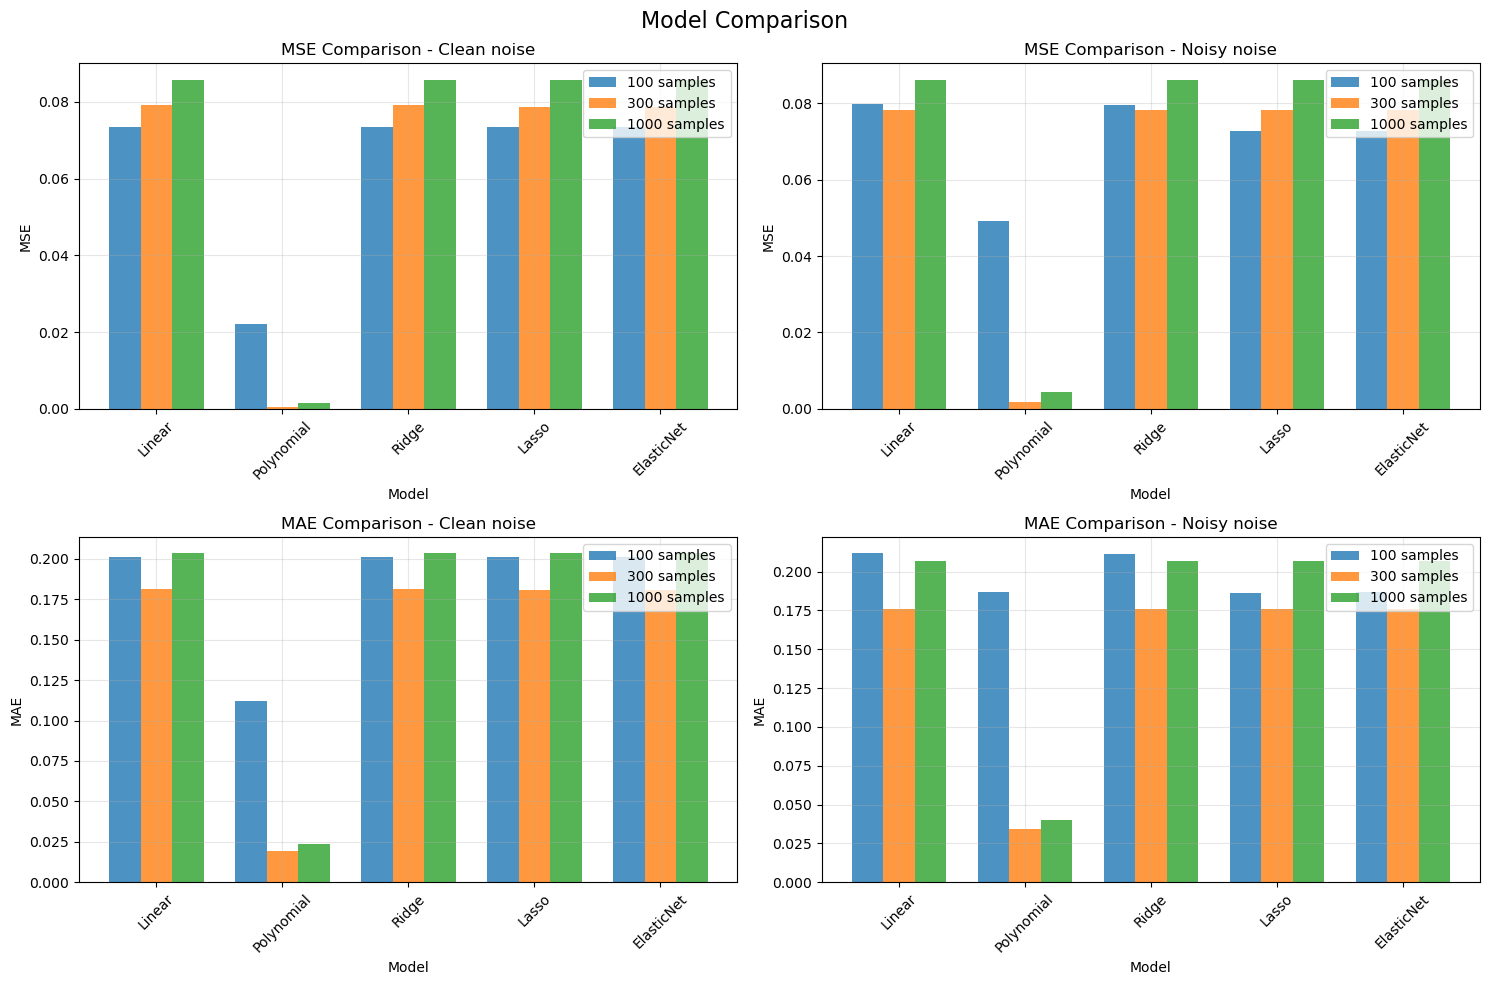

In [18]:
plot_comparison(results_no_outliers, n_samples_list, noise_levels, add_outliers_flag=False)